# RFM分析

## 分析の手順
1. 使用するデータセットを確認する
2. データセットを加工する
3. 分布を確認する
  - R（直近購買日）
  - F (購買頻度)
  - M (購買金額)
4. 顧客層の定義（ランクづけ）
5. ２次元描画（R,F）による解釈
6. ３次元描画（R,F,M）による解釈
7. クラスタリング分析による解釈

### 参考にする資料
・武器としてのデータ分析力	中西達夫、畠慎一郎 著　日本実業出版社  
・https://www.albert2005.co.jp/knowledge/marketing/customer_product_analysis/decyl_rfm

---

## １．使用するデータセットの確認

取得元：https://archive.ics.uci.edu/ml/datasets/Online+Retail

### 分析の目的
**探索的に既存顧客を分類したマップを作成する。**

想像できるビジネス上の課題・施策
- 離反しかけている顧客向けにキャンペーンを打ちたい
- 優良で見込みのある顧客に認知されていない製品を訴求したい


### 公開されていた情報
- イギリスのオンライン通販業者（実店舗を持たない）の取引データ
- 同社は主にギフトを販売している
- 主な顧客は卸売業者（多国籍）
- 対象の期間は、2010-01-12〜2010-12-11


物理名 | 論理名 | 設定したいデータ型
--|--|--
InvoiceNo | 請求書番号（Cで始まる場合はキャンセル） | object
StockCode | 製品コード | object
Description | 製品名 | object
Quantity | 数量 | int64
InvoiceDate | 請求日 | datetime64
UnitPrice | 単価（ポンド） | float64
CustomerID | 顧客コード | object
Country | 居住国 | object


### 想定できるビジネス上の考慮点
- マーケティングはWeb広告、メールがメインか
- 取引先が広域で、ロジスティクスにかかるコストは大きいはず
- 受注量に応じたディスカウントが存在しそう


### データセットを目検して気づいたこと
- 扱う製品は雑貨っぽい
- CustomerIDがNullのレコードが存在する
- StockCode, Description, UnitPricedeで一意にはならない
  - 製品を示さないコード値がある
  - 製品名が入っていない
  - 単価が異なる

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [2]:
# Online_Retail.xlsx をデータフレーム化
df = pd.read_excel("Online_Retail.xlsx", sheetname="Online Retail")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# データ型の確認
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
# 基礎統計量の確認
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [5]:
# CustomerIDがNaNのレコードは除外、データ型をobjectに修正
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype('object')
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [6]:
# 基礎統計量の再確認
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,406829.0,406829,406829,406829.000000,406829,406829.000000,406829.0,406829
unique,22190.0,3684,3896,NaN,20460,NaN,4372.0,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,17841.0,United Kingdom
freq,542.0,2077,2070,NaN,543,NaN,7983.0,361878
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.061303,NaN,3.460471,NaN,NaN
std,NaN,NaN,NaN,248.693370,NaN,69.315162,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN


In [7]:
# キャンセルレコードを目検しておく
df[df['InvoiceNo'].str.startswith('C', na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### 気づいたこと（CustomerIDがNaNのレコード除外後のデータセットで）
- 22,190件の請求履歴
- 数量、単価のばらつきは大きい
- 大きな数量の誤発注(80,995)からキャンセルがあった模様
- 37ヶ国、4,372のカスタマー
- 注意事項
  - **ディスカウント額は、別レコードとして持っている**
  - 3,684の製品コードに対し、3,896の製品名称？
  - POSTAGE,CARRIAGE,Manual,CRUK Commissionのマイナス数量レコードあり
  - Discount,POSTAGE,Manual,CARRIAGE,CRUK Commissionのプラス数量レコードあり

---

## ２. データセットの加工

In [8]:
# １レコードあたりの注文金額を算出してカラム追加（キャンセルやディスカウントはマイナスになる）
df['Price'] = df['UnitPrice'] * df['Quantity']
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00


In [9]:
# 金額がマイナスのレコードを確認
df[df['Price'] < 0].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80


**このデータフレームをベースに分析を進めていく**

---

## ３．分布を確認する

### <u>３−１．"R"ecency (直近購入日)</u>

In [10]:
# CustomerIDで一意な直近購入日をもつDataFrameの作成
R_df = DataFrame(df, columns=['CustomerID','InvoiceDate'])
R_df['InvoiceDate'] = R_df.InvoiceDate.map(lambda x: x.strftime('%Y-%m-%d'))
R_df = R_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
R_df.head()

,CustomerID,InvoiceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [11]:
# 直近購入日ごとのカスタマー数を集計
R_bar = R_df.groupby(['InvoiceDate']).count().reset_index().rename(columns={'CustomerID':'NumofCS'})
R_bar.head()

,InvoiceDate,NumofCS
0,2010-12-01,15
1,2010-12-02,18
2,2010-12-03,7
3,2010-12-05,3
4,2010-12-06,5


In [12]:
R_bar.describe(include='all')

,InvoiceDate,NumofCS
count,304,304.000000
unique,304,NaN
top,2011-07-31,NaN
freq,1,NaN
mean,NaN,14.381579
std,NaN,18.716729
min,NaN,1.000000
25%,NaN,5.000000
50%,NaN,7.000000
75%,NaN,14.000000


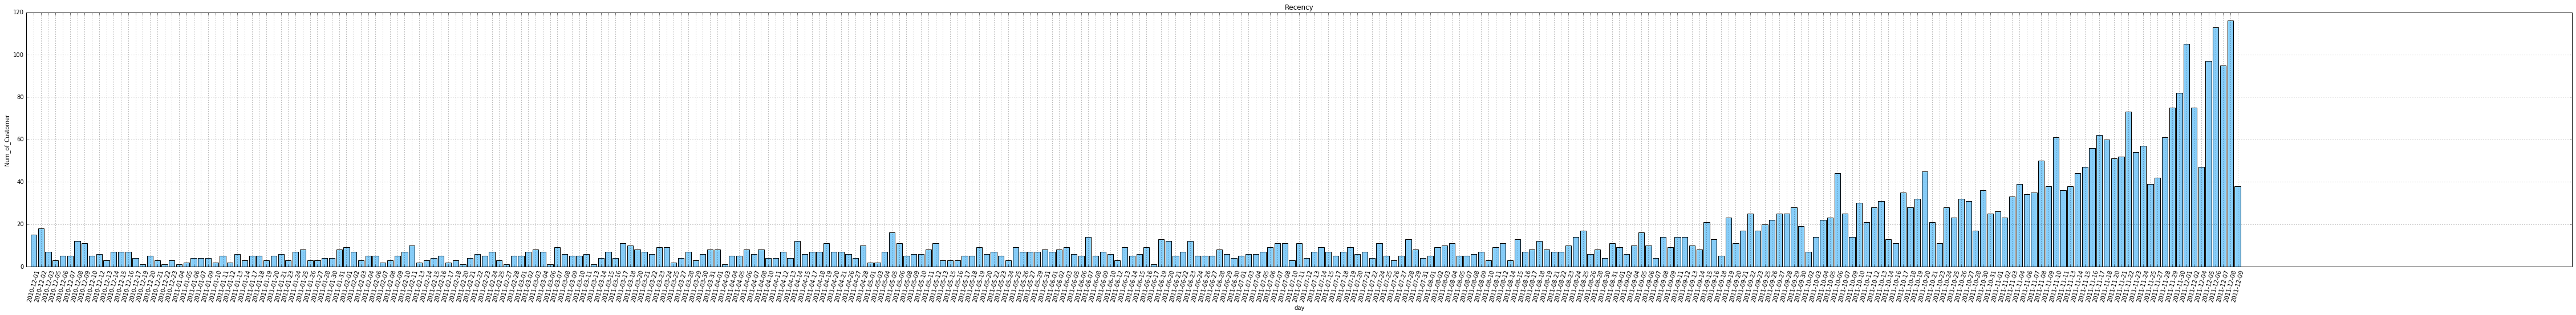

In [13]:
# Recency (直近購入日)の分布を確認
plt.figure(figsize=(80, 8))
plt.bar(np.arange(1,R_bar['InvoiceDate'].nunique()+1), R_bar.NumofCS.as_matrix(), tick_label=R_bar.InvoiceDate, align="center", color='lightskyblue')

plt.title("Recency")
plt.xlabel("day")
plt.xticks(rotation = 75)
plt.ylabel("Num_of_Customer")

plt.grid(True)

**Recencyは概ね一般的な分布パターンに当てはまり、直近になるほどカスタマー数は多い**

### <u>３−２．"F"requency (購入頻度)</u>

In [14]:
# CustomerIDで一意な購入回数をもつDataFrameの作成
F_df = DataFrame(df, columns=['CustomerID','InvoiceNo'])
F_df = F_df.groupby('CustomerID')['InvoiceNo'].count().reset_index().rename(columns={'InvoiceNo':'NumofInvoice'})
F_df.head()

,CustomerID,NumofInvoice
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
# 購入回数ごとにカスタマー数を集計
F_bar = F_df.groupby(['NumofInvoice']).count().reset_index().rename(columns={'CustomerID':'NumofCS'})
F_bar.head()

,NumofInvoice,NumofCS
0,1,79
1,2,59
2,3,53
3,4,55
4,5,61


In [16]:
F_bar.describe(include='all')

,NumofInvoice,NumofCS
count,474.000000,474.000000
mean,361.552743,9.223629
std,614.915672,15.496183
min,1.000000,1.000000
25%,119.250000,1.000000
50%,242.500000,3.000000
75%,411.500000,10.000000
max,7983.000000,79.000000


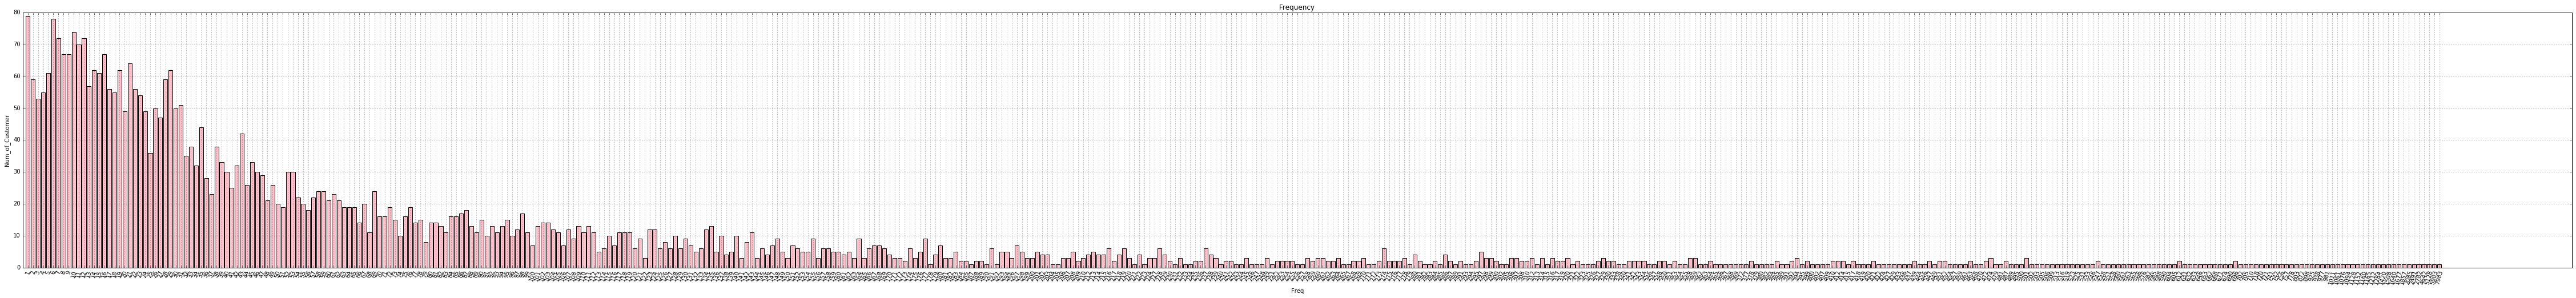

In [17]:
# Frequency (購入頻度)の分布を確認
plt.figure(figsize=(80, 8))
plt.bar(np.arange(1,F_bar['NumofInvoice'].nunique()+1), F_bar.NumofCS.as_matrix(), tick_label=F_bar.NumofInvoice, align="center", color='pink')

plt.title("Frequency")
plt.xlabel("Freq")
plt.xticks(rotation = 75)
plt.ylabel("Num_of_Customer")

plt.grid(True)

**Frequencyも概ね一般的な分布パターンに当てはまり、購入頻度が少ないカスタマーが多く、購入頻度が上がるにつれてカスタマー数は減っていく**

### <u>３−３．"M"onetary (累積購入金額)</u>

In [18]:
# CustomerIDで一意な累積購入金額をもつDataFrameの作成
M_df = DataFrame(df, columns=['CustomerID','Price'])
M_df = M_df.groupby('CustomerID')['Price'].count().reset_index().rename(columns={'Price':'TotalPrice'})
M_df.head()

,CustomerID,TotalPrice
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [19]:
# 累積購入金額を恣意的にビニング
price_bin = [0,25,50,100,200,300,400,500,600,700,800,900,1000
,2000,3000,4000,5000,6000,7000,8000]
price_bin_label = ['~25','~50','~100','~200','~300','~400','~500','~600','~700','~800','~900','~1000'
,'~2000','~3000','~4000','~5000','~6000','~7000','~8000']
M_df['TotalPriceBin'] = pd.cut(M_df.TotalPrice, price_bin, labels=price_bin_label)
M_df.head()

,CustomerID,TotalPrice,TotalPriceBin
0,12346.0,2,~25
1,12347.0,182,~200
2,12348.0,31,~50
3,12349.0,73,~100
4,12350.0,17,~25


In [20]:
# ビニングした累積購入金額ごとのカスタマー数を集計
M_bar = M_df.drop('TotalPrice',axis=1).groupby(['TotalPriceBin']).count().reset_index().rename(columns={'CustomerID':'NumofCS'})
M_bar.head()

,TotalPriceBin,NumofCS
0,~25,1535
1,~50,904
2,~100,825
3,~200,637
4,~300,227


In [21]:
M_bar.describe(include='all')

,TotalPriceBin,NumofCS
count,19,19.000000
unique,19,NaN
top,~8000,NaN
freq,1,NaN
mean,NaN,230.105263
std,NaN,429.494263
min,NaN,0.000000
25%,NaN,2.500000
50%,NaN,15.000000
75%,NaN,164.500000


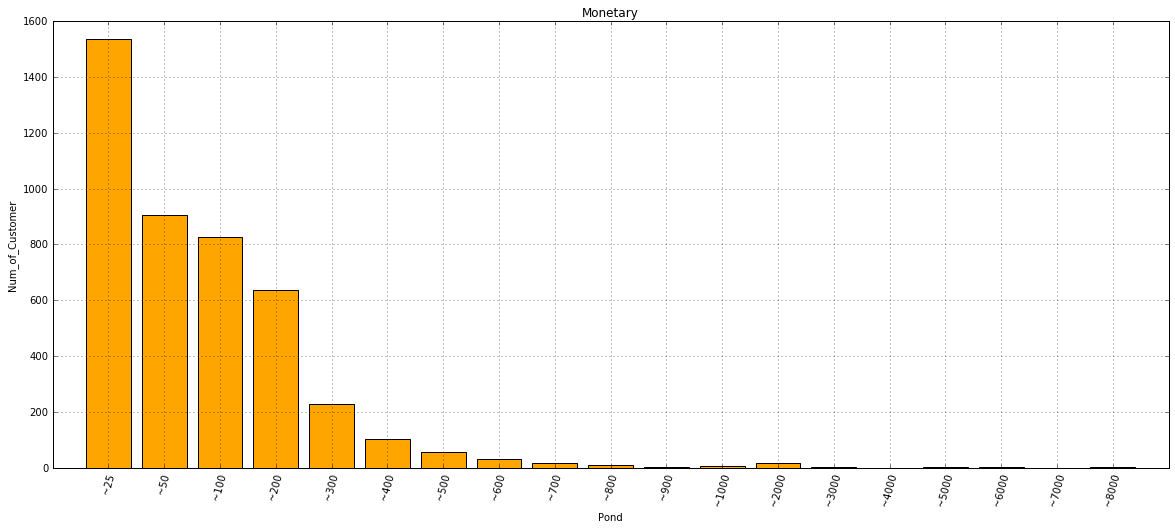

In [22]:
# Monetary (累積購入金額)の分布を確認
plt.figure(figsize=(20, 8))
plt.bar(np.arange(1,M_bar['TotalPriceBin'].nunique()+1), M_bar.NumofCS.as_matrix(), tick_label=M_bar.TotalPriceBin, align="center", color='orange')

plt.title("Monetary")
plt.xlabel("Pond")
plt.xticks(rotation = 75)
plt.ylabel("Num_of_Customer")

plt.grid(True)

**Monetaryは中間でピークができることなく、少額取引が多い分布**  
（通販事業では、送料の関係から中間にピークができる場合がある。）

## ４．ランクづけと解釈

4,372のカスタマーを５階層でランクづけする

In [23]:
bin_value = [0,900,1800,2700,3600,4500]
bin_label = [1,2,3,4,5]

### <u>４−１．"R"ecency (直近購入日)のランクづけ</u>

In [39]:
R_Rdf = R_df.copy()
# タイムスタンプから日付に変換
R_Rdf['InvoiceDate'] = R_Rdf.InvoiceDate.map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# 全データの最終購入日付を取得しカスタマー別に最終購入日との差を取得
latest = R_Rdf['InvoiceDate'].max()
R_Rdf['InvoiceDate'] = R_Rdf.InvoiceDate.map(lambda x: (latest - x).days)
# 最終購入日との差で順位づけ
R_Rdf = R_Rdf.assign(order=stats.mstats.rankdata(R_Rdf.InvoiceDate))
R_Rdf.head()

,CustomerID,InvoiceDate,order
0,12346.0,325,4204.0
1,12347.0,2,202.0
2,12348.0,75,2730.5
3,12349.0,18,1195.5
4,12350.0,310,4135.0


In [40]:
# Recencyをランキング
r_bin_value = [0,900,1800,2700,3600,4500]
r_bin_label = [5,4,3,2,1]

R_Rdf['Rank'] = pd.cut(R_Rdf.order, r_bin_value, labels=r_bin_label)
R_Rdf.head()

,CustomerID,InvoiceDate,order,Rank
0,12346.0,325,4204.0,1
1,12347.0,2,202.0,5
2,12348.0,75,2730.5,2
3,12349.0,18,1195.5,4
4,12350.0,310,4135.0,1


In [41]:
drop_col = ['InvoiceDate','order']
R_Rdf = R_Rdf.rename(columns={'Rank': 'R_Rank'}).drop(drop_col,axis=1)
R_Rdf.head()

,CustomerID,R_Rank
0,12346.0,1
1,12347.0,5
2,12348.0,2
3,12349.0,4
4,12350.0,1


In [42]:
R_Rdf.describe(include='all')

,CustomerID,R_Rank
count,4372.000000,4372.0
unique,NaN,5.0
top,NaN,5.0
freq,NaN,904.0
mean,15299.677722,NaN
std,1722.390705,NaN
min,12346.000000,NaN
25%,13812.750000,NaN
50%,15300.500000,NaN
75%,16778.250000,NaN


### <u>４−２．"F"requency (購入頻度)のランクづけ</u>

In [43]:
F_Rdf = F_df.copy()
# 請求回数でランク付け
F_Rdf = F_Rdf.assign(order=stats.mstats.rankdata(F_Rdf.NumofInvoice))
F_Rdf.head()

,CustomerID,NumofInvoice,order
0,12346.0,2,109.0
1,12347.0,182,3847.0
2,12348.0,31,1829.0
3,12349.0,73,2898.0
4,12350.0,17,1082.5


In [44]:
# Frequencyをビニング
F_Rdf['Rank'] = pd.cut(F_Rdf.order, bin_value, labels=bin_label)
F_Rdf.head()

,CustomerID,NumofInvoice,order,Rank
0,12346.0,2,109.0,1
1,12347.0,182,3847.0,5
2,12348.0,31,1829.0,3
3,12349.0,73,2898.0,4
4,12350.0,17,1082.5,2


In [45]:
drop_col = ['NumofInvoice','order']
F_Rdf = F_Rdf.rename(columns={'Rank': 'F_Rank'}).drop(drop_col,axis=1)
F_Rdf.head()

,CustomerID,F_Rank
0,12346.0,1
1,12347.0,5
2,12348.0,3
3,12349.0,4
4,12350.0,2


In [46]:
F_Rdf.describe(include='all')

,CustomerID,F_Rank
count,4372.000000,4372.0
unique,NaN,5.0
top,NaN,1.0
freq,NaN,926.0
mean,15299.677722,NaN
std,1722.390705,NaN
min,12346.000000,NaN
25%,13812.750000,NaN
50%,15300.500000,NaN
75%,16778.250000,NaN


### <u>４−３．"M"onetary (累積購入金額)のランクづけ</u>

In [47]:
M_Rdf = M_df.copy()
# 累計購入金額でランクづけ
M_Rdf = M_Rdf.assign(order=stats.mstats.rankdata(M_Rdf.TotalPrice))
M_Rdf.head()

,CustomerID,TotalPrice,TotalPriceBin,order
0,12346.0,2,~25,109.0
1,12347.0,182,~200,3847.0
2,12348.0,31,~50,1829.0
3,12349.0,73,~100,2898.0
4,12350.0,17,~25,1082.5


In [48]:
# Monetaryをビニング
M_Rdf['Rank'] = pd.cut(M_Rdf.order, bin_value, labels=bin_label)
M_Rdf.head()

,CustomerID,TotalPrice,TotalPriceBin,order,Rank
0,12346.0,2,~25,109.0,1
1,12347.0,182,~200,3847.0,5
2,12348.0,31,~50,1829.0,3
3,12349.0,73,~100,2898.0,4
4,12350.0,17,~25,1082.5,2


In [49]:
drop_col = ['TotalPrice','TotalPriceBin','order']
M_Rdf = M_Rdf.rename(columns={'Rank': 'M_Rank'}).drop(drop_col,axis=1)
M_Rdf.head()

,CustomerID,M_Rank
0,12346.0,1
1,12347.0,5
2,12348.0,3
3,12349.0,4
4,12350.0,2


In [50]:
M_Rdf.describe(include='all')

,CustomerID,M_Rank
count,4372.000000,4372.0
unique,NaN,5.0
top,NaN,1.0
freq,NaN,926.0
mean,15299.677722,NaN
std,1722.390705,NaN
min,12346.000000,NaN
25%,13812.750000,NaN
50%,15300.500000,NaN
75%,16778.250000,NaN


### <u>４−４．RFMで集約</u>

In [51]:
RF_df_g = pd.merge(R_Rdf,F_Rdf,on=['CustomerID'],how='left')
RFM_df_g = pd.merge(RF_df_g,M_Rdf,on=['CustomerID'],how='left')

RFM_df_g['Total_Rank'] = RFM_df_g['R_Rank'] + RFM_df_g['F_Rank'] + RFM_df_g['M_Rank']
RFM_df_g.head()

# RFM_df_g.sort_values(by=["Total_Rank"], ascending=True)

,CustomerID,R_Rank,F_Rank,M_Rank,Total_Rank
0,12346.0,1,1,1,3
1,12347.0,5,5,5,15
2,12348.0,2,3,3,8
3,12349.0,4,4,4,12
4,12350.0,1,2,2,5


In [52]:
RFM_df_g.describe()

,CustomerID,R_Rank,F_Rank,M_Rank,Total_Rank
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,3.058554,2.936642,2.936642,8.931839
std,1722.390705,1.393600,1.399370,1.399370,3.684779
min,12346.000000,1.000000,1.000000,1.000000,3.000000
25%,13812.750000,2.000000,2.000000,2.000000,6.000000
50%,15300.500000,3.000000,3.000000,3.000000,9.000000
75%,16778.250000,4.000000,4.000000,4.000000,12.000000
max,18287.000000,5.000000,5.000000,5.000000,15.000000


In [53]:
# ランクごとのカスタマー数を見ておく
SD = RFM_df_g.groupby(['Total_Rank'])['CustomerID'].count().reset_index()
SD

,Total_Rank,CustomerID
0,3,352
1,4,244
2,5,404
3,6,345
4,7,369
5,8,341
6,9,352
7,10,333
8,11,384
9,12,299


In [54]:
# 標準偏差
SD.CustomerID.std()

50.020636766879555

このばらつき具合が許容範囲内かどうか判断するための方法はないだろうか...？

---

## 描画の準備

カスタマごとに
- "R"ecency (直近購入日)
- "F"requency (購入頻度)
- "M"onetary (累積購入金額)

の指標を出しておく

In [55]:
# 必要なカラムだけ取得
RFM_df = DataFrame(df, columns=['CustomerID','InvoiceDate','Price','StockCode'])
# 直近の購入日を取得し、最終日起点で日差をとる
latest = RFM_df['InvoiceDate'].max()
RFM_df['InvoiceDate'] = df.InvoiceDate.map(lambda x: (latest - x).days)
# 購入頻度を算出
RFM_df['Times'] = df.Quantity.map(lambda x: 1 if x > 0 else -1)
RFM_df.head()

,CustomerID,InvoiceDate,Price,StockCode,Times
0,17850,373,15.30,85123A,1
1,17850,373,20.34,71053,1
2,17850,373,22.00,84406B,1
3,17850,373,20.34,84029G,1
4,17850,373,20.34,84029E,1


In [56]:
RFM_df.describe(include='all')

,CustomerID,InvoiceDate,Price,StockCode,Times
count,406829.0,406829.000000,406829.000000,406829,406829.000000
unique,4372.0,NaN,NaN,3684,NaN
top,17841.0,NaN,NaN,85123A,NaN
freq,7983.0,NaN,NaN,2077,NaN
mean,NaN,151.316074,20.401854,NaN,0.956222
std,NaN,112.869646,427.591718,NaN,0.292641
min,NaN,0.000000,-168469.600000,NaN,-1.000000
25%,NaN,49.000000,4.200000,NaN,1.000000
50%,NaN,131.000000,11.100000,NaN,1.000000
75%,NaN,246.000000,19.500000,NaN,1.000000


In [57]:
RFM_df.dtypes

CustomerID      object
InvoiceDate      int64
Price          float64
StockCode       object
Times            int64
dtype: object

In [58]:
# 取り扱い不明な製品コードを持つレコードを除外
drop_code = ['BANK CHARGES','C2','CRUK','D','DOT','M','PADS','POST']
F_df_p = RFM_df.loc[~df.StockCode.isin(drop_code)]
F_df_p.head()

,CustomerID,InvoiceDate,Price,StockCode,Times
0,17850,373,15.30,85123A,1
1,17850,373,20.34,71053,1
2,17850,373,22.00,84406B,1
3,17850,373,20.34,84029G,1
4,17850,373,20.34,84029E,1


In [59]:
F_df_p.describe(include='all')

,CustomerID,InvoiceDate,Price,StockCode,Times
count,404909.0,404909.000000,404909.000000,404909,404909.000000
unique,4363.0,NaN,NaN,3676,NaN
top,17841.0,NaN,NaN,85123A,NaN
freq,7971.0,NaN,NaN,2077,NaN
mean,NaN,151.297951,20.465496,NaN,0.957823
std,NaN,112.878768,422.775982,NaN,0.287360
min,NaN,0.000000,-168469.600000,NaN,-1.000000
25%,NaN,49.000000,4.200000,NaN,1.000000
50%,NaN,131.000000,10.900000,NaN,1.000000
75%,NaN,246.000000,19.500000,NaN,1.000000


In [60]:
# 最新購入日までの日数
R_df_p = RFM_df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
# 購入頻度
F_df_p = F_df_p.groupby('CustomerID')['Times'].sum().reset_index()
# 累計購入額
M_df_p = RFM_df.groupby('CustomerID')['Price'].sum().reset_index()

RF_df_p = pd.merge(R_df_p,F_df_p,on=['CustomerID'],how='left')
RFM_df_p = pd.merge(RF_df_p,M_df_p,on=['CustomerID'],how='left')
RFM_df_p.head()

,CustomerID,InvoiceDate,Times,Price
0,12346.0,325,0.0,0.00
1,12347.0,1,182.0,4310.00
2,12348.0,74,27.0,1797.24
3,12349.0,18,72.0,1757.55
4,12350.0,309,16.0,334.40


In [61]:
RFM_df_p.describe(include='all')

,CustomerID,InvoiceDate,Times,Price
count,4372.000000,4372.000000,4363.000000,4372.000000
mean,15299.677722,91.047118,88.890901,1898.459701
std,1722.390705,100.765435,223.357897,8219.345141
min,12346.000000,0.000000,-21.000000,-4287.630000
25%,13812.750000,16.000000,16.000000,293.362500
50%,15300.500000,49.000000,39.000000,648.075000
75%,16778.250000,142.000000,97.000000,1611.725000
max,18287.000000,373.000000,7705.000000,279489.020000


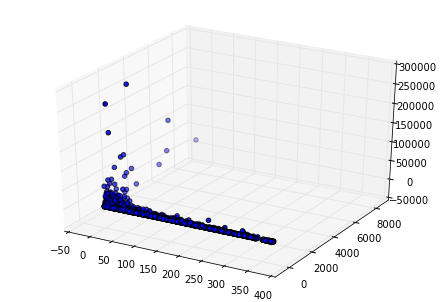

In [62]:
# ３次元の散布図で描画
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(RFM_df_p['InvoiceDate'], RFM_df_p['Times'], RFM_df_p['Price'])

**FrequencyとMonetaryの偏りが大きいため、対数を取る**

In [63]:
# 対数に変換
RFM_df_p['Times'] = RFM_df_p.Times.map(pd.np.log)
RFM_df_p['Price'] = RFM_df_p.Price.map(pd.np.log)

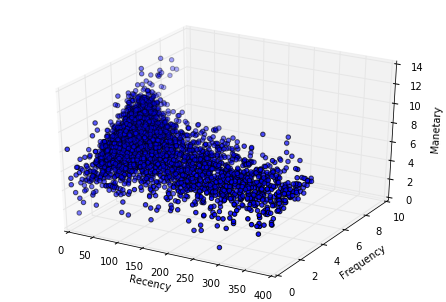

In [64]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlim(0, 400)
ax.set_ylim(0, 10)
ax.set_zlim(0, 14)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Manetary")

ax.scatter3D(RFM_df_p['InvoiceDate'], RFM_df_p['Times'], RFM_df_p['Price'])

**偏りは解消された**

In [65]:
# RFM分析によるランキングを付与
RFM_df_p_r = pd.merge(RFM_df_p,RFM_df_g,on=['CustomerID'],how='left')
RFM_df_p_r.head()

,CustomerID,InvoiceDate,Times,Price,R_Rank,F_Rank,M_Rank,Total_Rank
0,12346.0,325,-inf,-inf,1,1,1,3
1,12347.0,1,5.204007,8.368693,5,5,5,15
2,12348.0,74,3.295837,7.494007,2,3,3,8
3,12349.0,18,4.276666,7.471676,4,4,4,12
4,12350.0,309,2.772589,5.812338,1,2,2,5


## ５．２次元で描画する

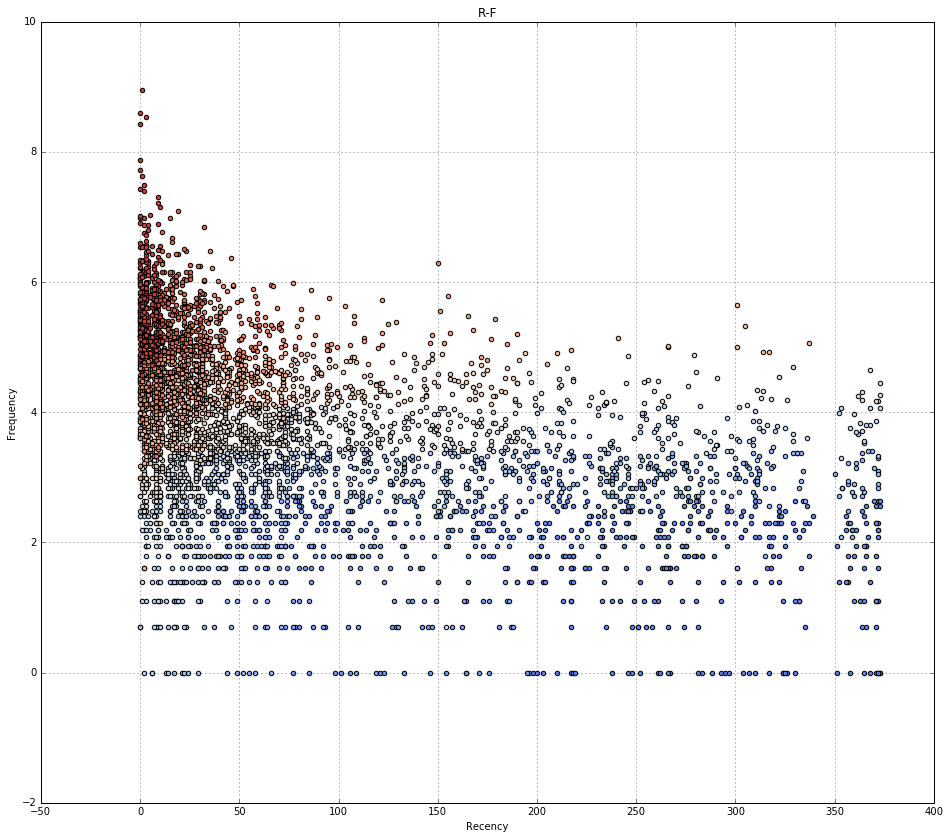

In [66]:
# RFで散布図を描画
plt.figure(figsize=(16, 14))
color = sns.color_palette("coolwarm", 14)

for i in range(14):
    plt_df = RFM_df_p_r[RFM_df_p_r['Total_Rank'] == i+2]
    x = plt_df['InvoiceDate']
    y = plt_df['Times']
    plt.scatter(x, y, c=color[i])

plt.title("R-F")
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.grid(True)

## ６．３次元で描画する

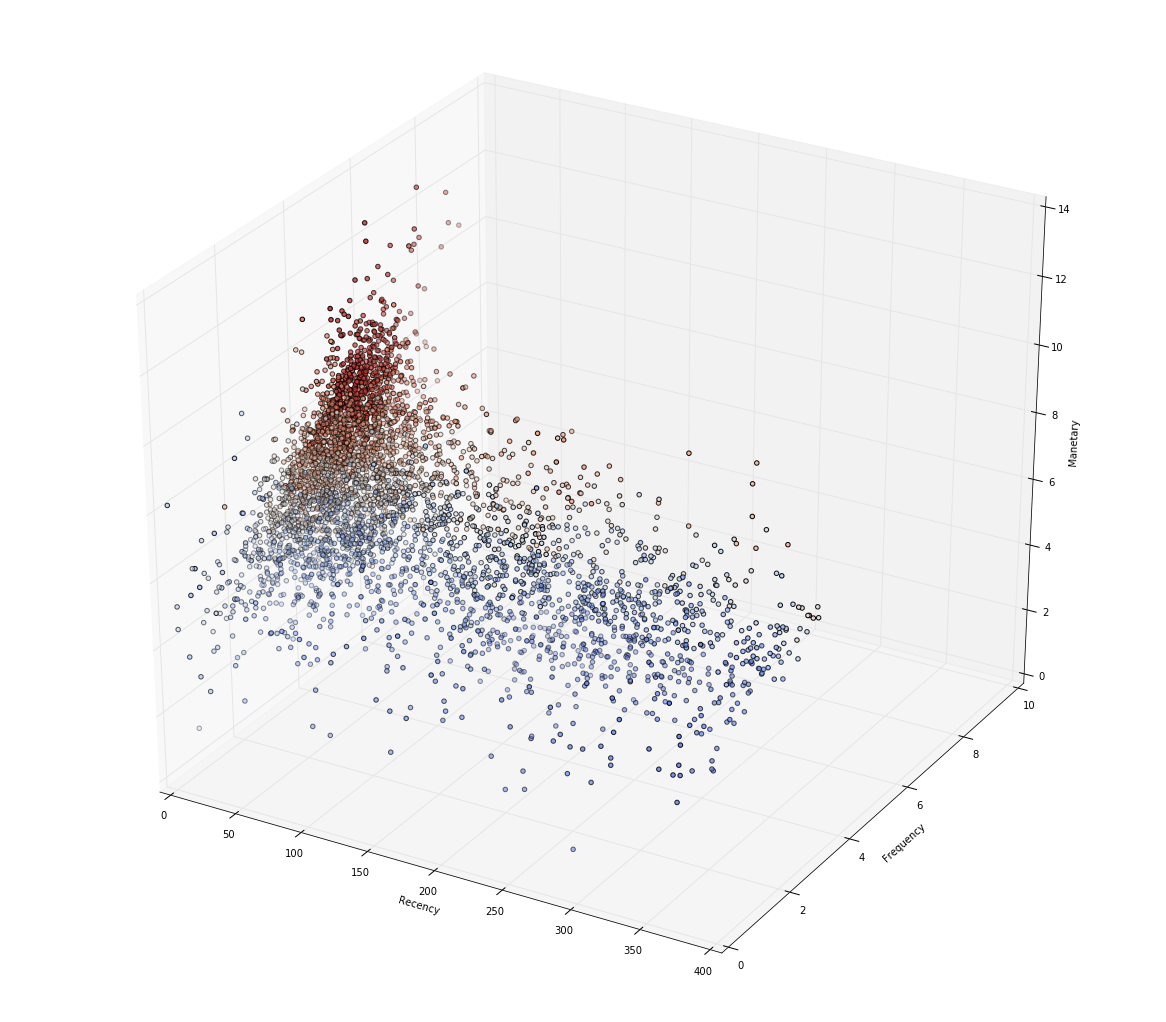

In [79]:
fig = plt.figure(figsize=(16, 14))
ax = Axes3D(fig)

color = sns.color_palette("coolwarm", 14)

for i in range(14):
    plt_df = RFM_df_p_r[RFM_df_p_r['Total_Rank'] == i+2]
    xs = plt_df['InvoiceDate']
    ys = plt_df['Times']
    zs = plt_df['Price']
    ax.scatter(xs, ys, zs, c=color[i])

ax.set_xlim(0, 400)
ax.set_ylim(0, 10)
ax.set_zlim(0, 14)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Manetary")